In [1]:
# Do all necessary preprocessing, calling prepro.py
import utils
from utils import *
importlib.reload(utils)

<module 'utils' from '/Users/gabrielarpino/Documents/ETH_Semester_1/Advanced_Machine_Learning/sdaml/task2/gabriel/utils.py'>

In [2]:
# Load data
X, X_test_original, y = load_data() 
y = y.ravel()
scores = np.array([])

# Now we construct different pipelines and test them using cross validation

The intermediate estimators have to have the fit and transform methods implemented, and the final estimator has to have the fit method implemented. If running cross validation, the models that should output a y (don't just transform data, like SVC or XGBClassifier need to have a predict method).

In [11]:
# Make a SVM pipeline
kf = KFold(n_splits=3, shuffle=True)

svm_estimators = [('standardization', preprocessing.StandardScaler()), 
              ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=300, random_state=42))),
              ('classifier', svm.SVC(class_weight='balanced'))
             ]
svm_pipe = Pipeline(svm_estimators)

score = cross_val_score(svm_pipe, X, y, cv=kf, scoring=make_scorer(balanced_accuracy_score))
print(score)

[0.6911946  0.67413993 0.68732523]


Normalized confusion matrix
[[0.82833333 0.03833333 0.13333333]
 [0.13194444 0.77277778 0.09527778]
 [0.08       0.02833333 0.89166667]]


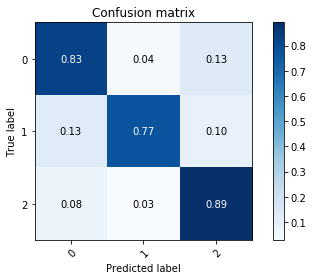

In [12]:
# Check confusion matrix:
svm_pipe.fit(X, y)
y_pred = svm_pipe.predict(X)
plot_confusion_matrix(y, y_pred, classes=[0, 1, 2],
                      title='Confusion matrix', normalize=True)
plt.show()

In [ ]:
# Make an XGBoost pipeline
kf = KFold(n_splits=3, shuffle=True)

xgb_estimators = [('standardization', preprocessing.StandardScaler()), 
              ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=300, random_state=42))),
              ('classifier', xgb.XGBClassifier(random_state=42))
             ]
xgb_pipe = Pipeline(xgb_estimators)

# xgb_score = cross_val_score(xgb_pipe, X, y, cv=kf, scoring=make_scorer(balanced_accuracy_score))
# print(xgb_score)

In [ ]:
# Check confusion matrix:
xgb_pipe.fit(X, y)
y_pred = xgb_pipe.predict(X)
plot_confusion_matrix(y, y_pred, classes=[0, 1, 2],
                      title='Confusion matrix', normalize=True)
plt.show()

In [ ]:
# Create an ensemble estimator of XGB and SVM:

kf = KFold(n_splits=3, shuffle=True)

ensemble = VotingClassifier([('svm', svm.SVC(class_weight='balanced')), 
                            ('xgb', xgb.XGBClassifier(random_state=42, learning_rate=0.5, n_estimators=300, max_depth=10))], 
                           weights=None)
ensemble_estimators = [('standardization', preprocessing.StandardScaler()), 
              ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=300, random_state=42))),
              ('classifier', ensemble)
             ]
ensemble_pipe = Pipeline(ensemble_estimators)

ensemble_score = cross_val_score(ensemble_pipe, X, y, cv=kf, scoring=make_scorer(balanced_accuracy_score), verbose=1)
print(ensemble_score)

In [3]:
# Try a SVM Estimator with SMOTE

kf = KFold(n_splits=3, shuffle=True)

svm_smote_estimators = [
              ('standardization', preprocessing.StandardScaler()), 
              ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=300, random_state=42))),
              ('classifier', SMOTEClassifier(SMOTE('minority'), svm.SVC()))
             ]
svm_smote_pipe = Pipeline(svm_smote_estimators)

score = cross_val_score(svm_smote_pipe, X, y, cv=kf, scoring=make_scorer(balanced_accuracy_score), verbose=2)
print(score)
# Score: [0.59077241 0.6063096  0.57785729]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=  22.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.1s remaining:    0.0s


[CV] ................................................. , total=  22.5s
[CV]  ................................................................
[CV] ................................................. , total=  21.3s
[0.59077241 0.6063096  0.57785729]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min finished


In [9]:
# Try a XGBC Estimator with SMOTE

kf = KFold(n_splits=3, shuffle=True)

xgb_smote_estimators = [
              ('standardization', preprocessing.StandardScaler()), 
              ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=300, random_state=42))),
              ('classifier', SMOTEClassifier(SMOTE('minority'), xgb.XGBClassifier()))
             ]
xgb_smote_pipe = Pipeline(xgb_smote_estimators)

# score = cross_val_score(xgb_smote_pipe, X, y, cv=kf, scoring=make_scorer(balanced_accuracy_score), verbose=2)
# print(score)
# Score: [0.56183764 0.53822128 0.61737798]

Normalized confusion matrix
[[0.94833333 0.05166667 0.        ]
 [0.14333333 0.85138889 0.00527778]
 [0.34166667 0.12166667 0.53666667]]


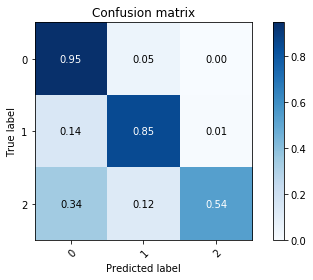

In [10]:
# Check confusion matrix:
xgb_smote_pipe.fit(X, y)
y_pred = xgb_smote_pipe.predict(X)
plot_confusion_matrix(y, y_pred, classes=[0, 1, 2],
                      title='Confusion matrix', normalize=True)
plt.show()

In [5]:
'''
BEST APPROACH SO FAR
    
Approach 2: 

model assessment via 5 fold CV 
class imbalance is taken care of by undersampling from class 1 
'''

#X and y are training x and y data 
#X_test_original corresponds to X_test.csv as given in the task 

X, X_test_original, y = load_data() 
y = y.ravel()
scores = np.array([])

kf = KFold(n_splits=2)
BMAC_scores = np.array([])

for train_index, test_index in kf.split(X):
    #define X_train and y_train as data in training folds (model is fitted here)
    #similarly, X_test, y_test as data in test fold (model is evaluated here)
    X_train, X_test = X[train_index], X[test_index]
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)

    y_train, y_test = y[train_index], y[test_index]
    y_train = pd.DataFrame(y_train)
    y_test = pd.DataFrame(y_test)
    
    y_train.columns = ['y']
    y_test.columns = ['y']
    
    #1. Zero Mean, Unit Variance
    print("Standardize data")
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train))
    X_test = scaler.transform(X_test)
    
    #2. Feature selection 
    print("Feature Selection")
    select = SelectFromModel(RandomForestClassifier(n_estimators=300, random_state=42))
    select.fit(X_train, y_train)
    X_train = pd.DataFrame(select.transform(X_train))
   
    '''
    #3. Outlier detection
    print("Outlier Detection")
    isf = IsolationForest(n_estimators=300, contamination=0.38)
    outliers = isf.fit_predict(X_train)
    unique, counts = np.unique(outliers, return_counts=True)
    count_dict = dict(zip(unique, counts))
    X_train = X_train[outliers == 1]
    y_train = y_train[outliers == 1]
    #DBScan = DBSCAN(eps = .5, metric=”euclidean”,min_samples = 30, n_jobs = -1)    
    #outliers = DBScan.fit_predict(X_train)
    '''
    
    '''
    #4. Undersampling from class 1 to offset class imbalance
    print('Undersampling')
    X_concat = pd.concat([X_train, y_train], axis=1)
    # separate minority and majority classes
    class_0 = X_concat[X_concat.y==0]
    class_1 = X_concat[X_concat.y==1]
    class_2 = X_concat[X_concat.y==2]

    #undersample majority class (1)
    class_1_under = resample(class_1,
                          replace=False, # sample with replacement
                          n_samples=len(class_0), # match number in minority classes
                          random_state=27) 
    undersampled = pd.concat([class_1_under, class_0, class_2])
    y_train = undersampled.y
    X_train = undersampled.drop('y', axis=1)
    '''
    #5. fitting model
    print("Fitting the model")
    #clf = xgb.XGBClassifier(random_state=42, learning_rate=0.5, n_estimators=300, max_depth=10)
    #clf = RandomForestClassifier(n_estimators=300, max_depth=10)
    class_weight = y_train.shape[0] / (3 * np.bincount((y_train.iloc[:,0]).astype(int)))
    class_weights0 = { 
    0 : class_weight[0],
    1 : class_weight[1],
    2 : class_weight[2]
    }
    
    ########## BO
    def classifier(c0_weight=class_weight[0], c1_weight=class_weight[1], c2_weight=class_weight[2], 
                   xtrain=X_train, ytrain=y_train, xtest=X_test, ytest=y_test):
        class_weights1 = { 
        0 : c0_weight,
        1 : c1_weight,
        2 : c2_weight
        }
        clf = svm.SVC(class_weight=class_weights1)

        clf.fit(xtrain, ytrain)

        #6. prediction 
        #print("Predicting")
        #selecting features based on training results
        #_test_selected = pd.DataFrame(select.transform(xtest))  #note: transform was previosuly fitted on training folds
        pred = clf.predict(xtrain)

        #scoring
        score = balanced_accuracy_score(ytrain, pred)
        #print(score)
        #scores = np.append(scores,score)
        return score


    # specify parameters and distributions to sample from
    param_dist = {"c0_weight": (0, 15), "c1_weight": (0, 12), "c2_weight": (0, 15)}

    optimizer = BayesianOptimization(
        f=classifier,
        pbounds=param_dist,
        verbose=2,
        random_state=5,
    )

    probe_params = {"c0_weight": class_weight[0], "c1_weight": class_weight[1], "c2_weight": class_weight[2]}
    optimizer.probe(
        params=probe_params,
        lazy=True
    )

    optimizer.maximize(
        init_points=3,
        n_iter=350,
    )

    print(optimizer.max)
    

    ########## BO
    class_weights_test = { 
    0 : optimizer.max['params']['c0_weight'],
    1 : optimizer.max['params']['c1_weight'],
    2 : optimizer.max['params']['c2_weight']
    }
    clf2 = svm.SVC(class_weight=class_weights_test)
    clf2.fit(X_train, y_train)
    print("Predicting")
    #selecting features based on training results
    X_test_selected = pd.DataFrame(select.transform(X_test))  #note: transform was previosuly fitted on training folds
    pred2 = clf2.predict(X_test_selected)
    #scoring
    score2 = balanced_accuracy_score(y_test, pred2)
    print('Test score:', score2)    
    scores = np.append(scores,score2)
    
    
##########################################################

truth = np.mean(scores)
std = np.std(scores)
print("mean expected error: ", truth, "std: ", std)

Standardize data
Feature Selection
Fitting the model
|   iter    |  target   | c0_weight | c1_weight | c2_weight |
-------------------------------------------------------------
|  1        |  0.8346   |  2.634    |  0.4472   |  2.602    |
|  2        |  0.6256   |  1.776    |  4.354    |  1.654    |
|  3        |  0.9062   |  7.349    |  2.442    |  4.894    |
|  4        |  0.8347   |  6.127    |  2.592    |  2.374    |
|  5        |  0.6345   |  8.0      |  0.0      |  8.0      |
|  6        |  0.6374   |  0.0      |  5.0      |  8.0      |
|  7        |  0.9194   |  8.0      |  5.0      |  8.0      |
|  8        |  0.3333   |  8.0      |  0.0      |  0.0      |
|  9        |  0.3333   |  0.0      |  0.0      |  8.0      |
|  10       |  0.8601   |  4.626    |  5.0      |  6.351    |
|  11       |  0.3333   |  0.0      |  0.0      |  0.0      |
|  12       |  0.8715   |  8.0      |  5.0      |  3.837    |
|  13       |  0.6155   |  4.954    |  0.0      |  4.49     |


In [ ]:
'''
Approach 4: 

model assessment via 5 fold CV 
class imbalance is taken care of by undersampling from class 1 
'''

#X and y are training x and y data 
#X_test_original corresponds to X_test.csv as given in the task 

X, X_test_original, y = load_data() 
y = y.ravel()
scores = np.array([])

kf = KFold(n_splits=5)
BMAC_scores = np.array([])

for train_index, test_index in kf.split(X):
    #define X_train and y_train as data in training folds (model is fitted here)
    #similarly, X_test, y_test as data in test fold (model is evaluated here)
    X_train, X_test = X[train_index], X[test_index]
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)

    y_train, y_test = y[train_index], y[test_index]
    y_train = pd.DataFrame(y_train)
    y_test = pd.DataFrame(y_test)
    
    y_train.columns = ['y']
    y_test.columns = ['y']
    
    smote = SMOTE('minority')
    X_train, y_train = smote.fit_sample(X_train, y_train)

    '''
    #undersampling from class 1 to offset class imbalance
    X_concat = pd.concat([X_train, y_train], axis=1)
    
    # separate minority and majority classes
    class_0 = X_concat[X_concat.y==0]
    class_1 = X_concat[X_concat.y==1]
    class_2 = X_concat[X_concat.y==2]

    #upsample minority -- classes 0 and 2
    class_1_under = resample(class_1,
                          replace=False, # sample with replacement
                          n_samples=len(class_0), # match number in minority classes
                          random_state=27) 

    undersampled = pd.concat([class_1_under, class_0, class_2])
   
    y_train = undersampled.y
    X_train = undersampled.drop('y', axis=1)
    '''
    
    
    #1. Zero Mean, Unit Variance
    print("Standardize data")
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
#################################################################
#begin fitting model to training folds -- X_train 

    #2. Feature selection 
    print("Feature Selection")
    select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
    select.fit(X_train, y_train)
    X_train = select.transform(X_train)

    #3. Outlier detection
    print("Outlier Detection")
    isf = IsolationForest(n_estimators=100, contamination=0.35)
    outliers = isf.fit_predict(X_train)
    
    #DBScan = DBSCAN(eps = .5, metric=”euclidean”,min_samples = 30, n_jobs = -1)    
    #outliers = DBScan.fit_predict(X_train)

    unique, counts = np.unique(outliers, return_counts=True)
    count_dict = dict(zip(unique, counts))
    X_train = X_train[outliers == 1]
    y_train = y_train[outliers == 1]
    
    print("Fitting the model")
    clf = xgb.XGBClassifier(random_state=42, learning_rate=0.5, n_estimators=100, max_depth=10)
    #clf = RandomForestClassifier(n_estimators=300, max_depth=10)
    clf.fit(X_train, y_train)
    
#end model fitting on X_train
############################################################
        
    #prediction 
    print("Predicting")
    #selecting features based on training results
    X_test = select.transform(X_test)
    pred = clf.predict(X_test)
    
    #scoring
    score = balanced_accuracy_score(y_test, pred)
    print(score)
    scores = np.append(scores,score)

##########################################################

truth = np.mean(scores)
std = np.std(scores)
print("mean expected error: ", truth, "std: ", std)

Standardize data
Feature Selection
Outlier Detection
Fitting the model
Predicting
0.5562480297533559
Standardize data
Feature Selection
Outlier Detection
Fitting the model
Predicting
0.5710455037919827
Standardize data
Feature Selection
Outlier Detection
Fitting the model
Predicting
0.5474442986943582
Standardize data
Feature Selection
Outlier Detection
Fitting the model
Predicting
0.5576211605644027
Standardize data
Feature Selection
Outlier Detection
Fitting the model
